# COMP 135 day09: MAP estimation for Logistic Regression

## Outline

* **Part 1: Understanding sigmoids and Logistic Regression as a model**
* **Part 2: Computing the MAP objective**
* **Part 3: Gradient descent for the MAP: Comparing 1st and 2nd order GD**

## Takeaways

* First-order methods are cheap but require many iterations
* Second-order methods are awesome, but still require careful step-size selection
* For all gradient descent methods, selecting step sizes is super important. Line search is needed!

In [2]:
import numpy as np
import pandas as pd
import scipy.stats

In [3]:
np.set_printoptions(precision=3, suppress=False)

In [4]:
pd.options.display.float_format = '{:,.3g}'.format  # show 3 digits of precision

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

# Part 1: The Probabilistic view of logistic regression

### Task: Binary classification

Given $N$ observations of *paired* feature-outcome observations: $\{ x_n, t_n \}$.

* Each input feature $x_n$ is a scalar real: $x_n \in \mathbb{R}$
* Each output or "label" or "outcome" $t_n$ is a scalar binary value: $t_n \in \{0, 1\}$

We're also given a feature transform function $\phi$ which maps each $x_n$ to a vector in $M$-dimensional space. This function is known in advance.

We want to make good predictions of new outcomes $t_*$ given new features $x_*$.



## Feature transformation

For now, we'll assume that the "feature transform" $\phi(x_n)$ just simply passes along the features $x_n$, while adding an additional offset or "intercept" feature that is always 1. This is a *simplifying* assumption for today.

In [6]:
def calc_features(x_N1, M=2):
    ''' Transform raw features into complete features useful for prediction
    
    Could do any non-linear transformations thought relevant for the problem.
    Here we'll just do an identity transform with an extra intercept feature.
    
    Args
    ----
    x_N1 : 2D array, shape (N, 1) = (n_examples,)
    
    Returns
    -------
    phi_NM : 2D array, shape (N, M) = (n_examples, n_transformed_features)
        First column will contain all ones (a bias or intercept feature)
        Second column will just include the raw features
    '''
    assert x_N1.ndim == 2
    assert x_N1.shape[1] == 1
    N = x_N1.shape[0]
    phi_NM = np.zeros((N, M))
    phi_NM[:,0] = 1
    phi_NM[:,1] = x_N1[:,0]
    return phi_NM

In [7]:
x_N1 = np.linspace(-1, 1, 5)[:,np.newaxis]

# Get transformed features using our "calc_features" function
# * first column will be all 1s, an "intercept"
# * second column will be the x values
calc_features(x_N1)

array([[ 1. , -1. ],
       [ 1. , -0.5],
       [ 1. ,  0. ],
       [ 1. ,  0.5],
       [ 1. ,  1. ]])

## Understanding the logistic sigmoid function

As discussed in your pre-recorded lectures, the *logistic sigmoid function* is:

\begin{align}
\sigma(r) = \frac{1}{1 + e^{-r}}
\end{align}

It maps real inputs $r \in (-\infty, +\infty)$ to the probability interval $(0, 1)$.

We call it a "sigmoid" function because it has an S-shaped curve, which you'll plot below.

This function is also sometimes called the "expit" function. 

We can use an existing implementation of this function available in SciPy:

* expit: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html

In [8]:
from scipy.special import expit as sigmoid

In [9]:
sigmoid(0)

0.5

In [10]:
sigmoid(-4)

0.01798620996209156

In [11]:
sigmoid(4)

0.9820137900379085

In [12]:
sigmoid(np.asarray([-6, -4, -2, 0, 2, 4, 6]))

array([0.002, 0.018, 0.119, 0.5  , 0.881, 0.982, 0.998])

## Exercise 1a: Plot the logistic sigmoid function 

We give you an array of G candidate $r$ values below.

In [13]:
G = 101
r_G = np.linspace(-8, 8, G)
sigmoid_of_r_G = sigmoid(np.asarray(r_G)) # TODO evaluate sigmoid at each r value

(-0.001, 1.001)

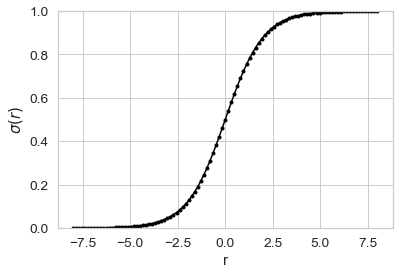

In [14]:
plt.plot(r_G, sigmoid_of_r_G, 'k.-');
plt.xlabel('r'); plt.ylabel('$\sigma(r)$');
plt.ylim([-0.001, 1.001])


## Define the Likelihood

Each observation (indexed by $n$) is drawn iid from a Bernoulli as follows:

$$
t_n | w \sim \text{BernPMF}\left( t_n | \sigma(w^T \phi(x_n)) \right)
$$

where $w \in \mathbb{R}^M$ is a weight vector, the same size as our feature vector $\phi(x_n) \in \mathbb{R}^M$

The key properties here are:
* The *mean* of $t_n$ is a *non-linear activation* of a linear function of the transformed features.

## Define the  Prior

For now, we'll assume that weights come from a zero mean prior with some covariance determined by a scalar parameter $\alpha$:

$$
w \sim \mathcal{N}( 0, \alpha^{-1} I_M )
$$

A zero mean prior makes sense if we don't know if the slope should be negative or positive.

### Parameter we'll treat as a random variable: $w$

* Weights vector: $w = [w_1, w_2, \ldots w_M]^T$, so $w \in \mathbb{R}^M$

### Parameters we'll treat as fixed: $\alpha$ 

* Prior precision $\alpha > 0$

The larger $\alpha$ is, the more confident we are in the weight values before seeing any data.


## Create a simple toy data for analysis

Just execute the cells below to get the sense of how to generate toy data from this model

We'll manually intervene to set the weight vector to a known value. This makes it easy to tell if our learning is working later on.

In [15]:
N = 10  # Number of examples we observe
M = 2     # Number of transformed features

Create the weight vector we'll use to generate our dataset. Set an intercept of 1.2 and a slope of -0.75

In [16]:
true_w_M = np.asarray([0.1, -0.25])

Create a "true" alpha value which controls the prior precision

In [17]:
true_alpha = 0.01

Create observed features $x$ and observed outputs $t$ manually

In [18]:
x_N1 = np.asarray([-5, -0.8, -0.7, -0.6, -0.4, 0.5, 0.8, 0.9, 4.3, 4.1]).reshape((N, 1))
phi_NM = calc_features(x_N1)

In [19]:
prng = np.random.RandomState(101) # reproducible random seed

In [20]:
t_N = (prng.rand(N) < sigmoid(np.dot(phi_NM, true_w_M))).astype(np.float64)

## Visualize the toy dataset

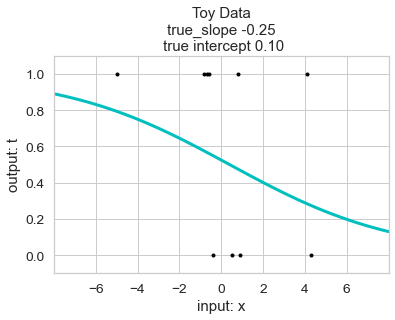

In [21]:
plt.plot(x_N1, t_N, 'k.');

ax_h = plt.gca()
ax_h.set_xlim([-8, 8]); ax_h.set_xticks([-6, -4, -2, 0, 2, 4, 6]);
ax_h.set_ylim([-.1, 1.1]);

xgrid_G1 = np.linspace(-8, 8, 100)[:,np.newaxis]
plt.plot(xgrid_G1, sigmoid(np.dot(calc_features(xgrid_G1), true_w_M)), 'c-', linewidth=3);

plt.xlabel('input: x');
plt.ylabel('output: t');
plt.title("Toy Data\n true_slope %.2f \n true intercept %.2f" % (
    true_w_M[1], true_w_M[0]));

## Discussion 1b: What about this observed dataset of 10 points would prefer a *negative* slope vs. a positive slope?

In [22]:
# TODO discuss

# Part 2: MAP estimation : View as optimization problem

There is NO closed form for the posterior over weights $p( w | t)$. 

However, we can evaluate (and thus optimize) the MAP objective, since this doesn't require knowing the full posterior.

Let's see how. Begin with the MAP optimization problem:

\begin{align}
    w^* = \arg \max_{w \in \mathbb{R}^M} ~~ p( w | t_{1:N} )
\end{align}

Rewriting using the log of the objective for tractability and simplifying via Bayes rule, we get the objective function to maximize is:

\begin{align}
\mathcal{M}(w) &= \log p( w | t_{1:N})
    \\
    &= \log p( w ) + \log p( t_{1:N} | w ) - \underbrace{\log p(t_{1:N})}_{\text{const wrt}~ w}
\end{align}

Thus, we can simply ignore the constant term, and maximize the following alternative objective:
\begin{align}
  \mathcal{M}'(w)  &= \log \text{MVNormPDF}( w | 0, \alpha^{-1} I_M ) + \sum_{n=1}^N \log \text{BernPMF}( t_n | \sigma(w^T \phi(x_n) ) 
\end{align}

Finally, we can *standardize* our problem by transforming so we *minimize* rather than *maximize*, just by multiplying by -1. Now the *loss* function we wish to minimize is:

\begin{align}
  \mathcal{L}(w)  &= - \log \text{MVNormPDF}( w | 0, \alpha^{-1} I_M ) - \sum_{n=1}^N \log \text{BernPMF}( t_n | \sigma(w^T \phi(x_n) ) 
\end{align}

Thus, we can find our optimal weights $w^*$ via:

\begin{align}
    w^* = \arg \min_{w \in \mathbb{R}^M} ~~ \mathcal{L}(w)
\end{align}

How can we compute each of these terms?

* Use `scipy.stats.multivariate_normal.logpdf` to evaluate the log prior PDF $\log \text{MVNormPDF}(\cdot)$
* For the likelihood pdf, use this formula:

$$
\sum_{n=1}^N \log \text{BernPMF}(t_n | p_n ) = \sum_{n=1}^N t_n \log p_n + (1-t_n) \log (1 - p_n)
$$

This is translated into the code below. 

In [191]:
def calc_sum_of_log_bern_pmf(t_N, p_N):
    ''' Calculate the log of the bernoulli pmf for N observations
    
    Args
    ----
    t_N : 1D array, shape (N,)
        Binary value (0 or 1) for each example n
    p_N : 1D array, shape (N,)
        Probability parameter of the Bernoulli for each example n
        
    Returns
    -------
    summed_logpmf : scalar float
        Summed log PMF over all N examples given
    '''
    # Make sure provided probabilities are not hard 0 or hard 1
    # so that the log values will not be numerically bad
    safe_p_N = np.minimum(np.maximum(p_N, 1e-100), 1 - 1e-13)
    return np.sum(np.log(safe_p_N)[t_N==1]) + np.sum(np.log(1-safe_p_N)[t_N==0])

## Exercise 2a: Compute the objective of our minimization problem

Translate the formula for $\mathcal{L}(w)$ above into concrete NumPy expressions

In [214]:
def calc_loss(wguess_M, phi_NM, t_N, alpha=0.1):
    ''' Compute the MAP loss objective function.
    
    The loss is equal to the negative log prior plus negative log likelihood
    
    Args
    ----
    w_M : 1D array, shape (M,)
        Weight parameter at which we want to evaluate the loss
    phi_NM : 2D array, shape (N,M)
        Observed input features
        Each row is a feature vector for one example
    t_N : 1D array, shape (N,)
        Observed outputs
        Each row is a output scalar value for one example
    alpha : positive scalar
        Prior precision
    
    Returns
    -------
    loss : scalar float
        The value of the loss function at provided w value
    '''

    log_prior_pdf = scipy.stats.multivariate_normal.logpdf(wguess_M, mean=np.zeros_like(wguess_M * 1/alpha),
                                                           cov=np.eye(len(wguess_M))/alpha) # TODO compute log prior pdf value
    
    
    log_lik_pdf = calc_sum_of_log_bern_pmf(t_N,sigmoid(np.dot(phi_NM,wguess_M))) # TODO compute log likelihood pdf value

    return -1 * log_prior_pdf + -1 * log_lik_pdf


## Exercise 2b: Evaluate the MAP objective (aka MAP loss function) at possible w values


In [215]:
phi_NM


array([[ 1. , -5. ],
       [ 1. , -0.8],
       [ 1. , -0.7],
       [ 1. , -0.6],
       [ 1. , -0.4],
       [ 1. ,  0.5],
       [ 1. ,  0.8],
       [ 1. ,  0.9],
       [ 1. ,  4.3],
       [ 1. ,  4.1]])

In [216]:
t_N

array([1., 1., 1., 1., 0., 0., 1., 0., 0., 1.])

In [217]:
np.log(0.5)

-0.6931471805599453

In [218]:
# Try with all zero weights
w1_M = np.zeros(M)
calc_loss(w1_M, phi_NM, t_N, true_alpha)

13.374519057996888

In [219]:
# Try with all weights set to 10
w2_M = 10 * np.ones(M)
calc_loss(w2_M, phi_NM, t_N, true_alpha)

117.57248385900087

In [220]:
# Try with all weights set to TRUE values

# TODO write code using calc_loss(...)

## Discussion 2c: Which value of the weight vector out of the 3 tried had the "best" loss  value? Does that agree with what you expect?

Use what you know about how this toy dataset was generated (hint: we know which weights were used to make the true observations).

In [221]:
# TODO discuss

## Demo: Visualizing the MAP objective as a contour plot

Step through the code below to see how we create a 2d contour plot visualization of our MAP optimization problem.

In [222]:
# Create a 2-dim grid of possible w values

G = 51 # G possible values for intercept
w0_grid_G = np.linspace(-2, 2, G)

H = 51 # H possible values for slope
w1_grid_H = np.linspace(-2, 2, H)

w0_GH, w1_GH = np.meshgrid(w0_grid_G, w1_grid_H,)

In [223]:
# Compute loss at each possible value in our grid
loss_GH = np.zeros((G, H))
for gg in range(G):
    for hh in range(H):
        cur_w_M = np.hstack([w0_GH[gg,hh], w1_GH[gg, hh]])        
        loss_GH[gg, hh] = calc_loss(cur_w_M, phi_NM, t_N, true_alpha)


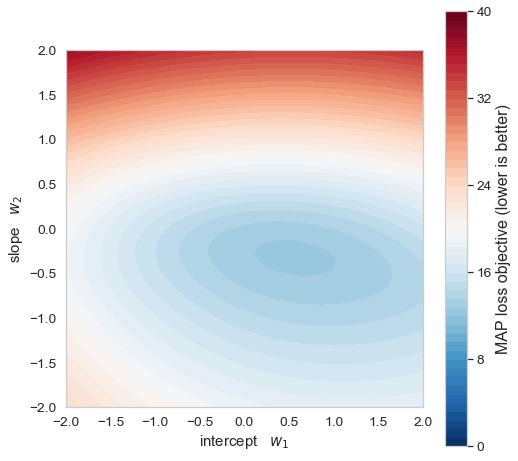

In [212]:
# Create a pretty contour plot over the grid of w[0], w[1], loss values

levels = np.linspace(0, 40, 51) # 50 evenly spaced levels

fig_handle, ax_handle = plt.subplots(nrows=1, ncols=1, figsize=(8,8));

ax_handle.contour(w0_GH, w1_GH, loss_GH, levels=levels, linewidths=0, colors='k')
cntrf_handle = ax_handle.contourf(w0_GH, w1_GH, loss_GH, levels=levels, cmap='RdBu_r', vmin=levels[0], vmax=levels[-1]);

cbar = plt.colorbar(cntrf_handle, ax=ax_handle)
cbar.set_label('MAP loss objective (lower is better)', fontsize=16);
cbar.set_ticks(levels[::10]);
plt.xlabel('intercept   $w_1$');
plt.ylabel('slope   $w_2$');
plt.gca().set_aspect('equal', 'box');

## Exercise 2d: Visually interpret the plot above. By inspection, which intercept and slope values are optimal? What is the loss at this optimal point?

In [213]:
# TODO interpret the plot and discuss with your group

## Exercise 2e: Numerically, search the grid of computed loss values `loss_GH` and determine the MAP value of weight vector

In [38]:
# TODO solve this cell

# Hint: you might find it easier to flatten each array of shape (G,H) into shape (L,) where L=G*H
loss_L = loss_GH.flatten()# new shape (G*H,)
w0_L = w0_GH.flatten()  # new shape (G*H,)
w1_L = w1_GH.flatten()  # new shape (G*H,)

# TODO find values of w0 (intercept) and w1 (slope) that minimize the loss

# Part 3: Gradients, Hessians, and Gradient Descent

### Gradient and Hessian formulas

We saw in lecture that we can compute the gradient and Hessian as:

\begin{align}
\nabla_w \mathcal{L} &= \Phi^T ( \sigma(\Phi w) - t ) + \alpha w
\\
\nabla_w \nabla_w \mathcal{L} &= \Phi^T R(w) \Phi  + \alpha I_M
\end{align}

where $R$ is a diagonal matrix given by 

$$
R = \text{diag}( \sigma(\Phi w) \sigma(- \Phi w ) )
$$

The functions below compute the gradient and Hessian. You don't need to do anything, just inspect them to gain understanding.

In [232]:
def calc_R(w_M, phi_NM):
    s_N = np.dot(phi_NM, w_M)
    R_NN = np.diag( sigmoid(s_N) * sigmoid(-s_N) )
    return R_NN

In [233]:
def calc_gradient_of_map_loss(w_M, phi_NM, t_N, alpha):
    ''' Calculate the gradient.
    
    Returns
    -------
    g_M : 1D array, shape (M,)
        Gradient vector evaluated at current weights w
    '''
    # Compute predicted probability of positive class
    yproba_N = sigmoid( np.dot(phi_NM, w_M) )
    return np.dot(phi_NM.T, (yproba_N - t_N)) + alpha * w_M

In [234]:
def calc_hessian_of_map_loss(w_M, phi_NM, t_N, alpha):
    ''' Calculate the Hessian.
    
    Returns
    -------
    H_MM : 2D array, shape (M,M)
        Hessian matrix evaluated at current weights w
    '''
    R_NN = calc_R(w_M, phi_NM)
    return np.dot(phi_NM.T, np.dot(R_NN, phi_NM)) + alpha * np.eye(M)

## First-order gradient descent

The code below performs 1st-order GD. 

While not converged, we perform the updates:

$$
w_{t+1} \gets w_t - \epsilon g( w_t )
$$

In [235]:
max_n_steps = 100

w_M = 1.5 * np.ones(M)

step_size = 0.2 # Selected by starting at 1.0, and trying smaller values until first 5 steps made loss better

GD1_history_of_w = [w_M]
GD1_history_of_loss = [calc_loss(w_M, phi_NM, t_N, true_alpha)]

for step in range(max_n_steps):
    
    # Compute gradient
    g_M = calc_gradient_of_map_loss(w_M, phi_NM, t_N, true_alpha)

    # Update the weights by taking a step downhill
    w_M = w_M - step_size * g_M
    
    # Print out progress
    cur_loss = calc_loss(w_M, phi_NM, t_N, true_alpha)
    print("step %3d/%d  loss %11.4f | gradient_norm %9.4f | intercept %9.3f | slope %9.3f" % (
        step, max_n_steps, cur_loss, np.sum(np.abs(g_M)), w_M[0], w_M[1]))
    GD1_history_of_loss.append(cur_loss)
    GD1_history_of_w.append(w_M)
    
    if step % 10:
        step_size = 0.95 * step_size  # slowly decay the step size
        
bestw_fromGD_M = w_M

step   0/100  loss     13.3582 | gradient_norm   12.4385 | intercept     1.231 | slope    -0.719
step   1/100  loss     12.9273 | gradient_norm    2.8867 | intercept     1.098 | slope    -0.275
step   2/100  loss     12.8019 | gradient_norm    2.4277 | intercept     0.878 | slope    -0.516
step   3/100  loss     12.6890 | gradient_norm    1.7594 | intercept     0.815 | slope    -0.262
step   4/100  loss     12.6510 | gradient_norm    1.5637 | intercept     0.708 | slope    -0.423
step   5/100  loss     12.6150 | gradient_norm    1.0530 | intercept     0.683 | slope    -0.278
step   6/100  loss     12.6012 | gradient_norm    0.8692 | intercept     0.634 | slope    -0.363
step   7/100  loss     12.5921 | gradient_norm    0.5274 | intercept     0.620 | slope    -0.299
step   8/100  loss     12.5887 | gradient_norm    0.3724 | intercept     0.599 | slope    -0.330
step   9/100  loss     12.5872 | gradient_norm    0.2076 | intercept     0.590 | slope    -0.311
step  10/100  loss     12.5866

## Discussion 3a: Compare the GD estimate of the best weights $w$ to those found via grid search


In [243]:
print("Optimal weights via grid search")
bestid = np.argmin(loss_GH.flatten())
bestw_fromgridsearch_M = np.asarray([w0_GH.flatten()[bestid], w1_GH.flatten()[bestid]])
print(bestw_fromgridsearch_M)

print("Optimal weights via 1st order gradient descent")
print(w_M)



Optimal weights via grid search
[ 0.56 -0.32]
Optimal weights via 1st order gradient descent
[ 0.556 -0.311]


array([ 0.1 , -0.25])

In [240]:
 calc_loss(bestw_fromgridsearch_M, phi_NM, t_N, true_alpha)

12.586377290924254

In [241]:
 calc_loss(bestw_fromGD_M, phi_NM, t_N, true_alpha)

12.58596121296004

In [242]:
# TODO discuss: which is better? are they similar?

# Second order gradient descent

In [250]:
max_n_steps = 100

w_M = 1.5 * np.ones(M)

step_size = 0.15 # Selected by starting at 1.0, and trying smaller values until first 5 steps made loss better

GD2_history_of_w = [w_M]
GD2_history_of_loss = [calc_loss(w_M, phi_NM, t_N, true_alpha)]

for step in range(max_n_steps):
    
    g_M = calc_gradient_of_map_loss(w_M, phi_NM, t_N, true_alpha)
    H_MM = calc_hessian_of_map_loss(w_M, phi_NM, t_N, true_alpha)
    w_M = w_M - step_size * np.linalg.solve(H_MM, g_M) # compute H^1 times g
    cur_loss = calc_loss(w_M, phi_NM, t_N, true_alpha)
    
    print("step %3d/%d  loss %11.4f | gradient_norm %9.4f | intercept %9.3f | slope %9.3f" % (
        step, max_n_steps, cur_loss, np.sum(np.abs(g_M)), w_M[0], w_M[1]))
    GD2_history_of_loss.append(cur_loss)
    GD2_history_of_w.append(w_M)
    
    if step % 10:
        step_size = 0.95 * step_size # slowly decay step size

step   0/100  loss     23.7395 | gradient_norm   12.4385 | intercept    -0.466 | slope    -2.940
step   1/100  loss     12.8758 | gradient_norm    6.3231 | intercept     0.627 | slope    -0.103
step   2/100  loss     12.8023 | gradient_norm    3.1766 | intercept     0.613 | slope    -0.129
step   3/100  loss     12.7502 | gradient_norm    2.7249 | intercept     0.603 | slope    -0.151
step   4/100  loss     12.7126 | gradient_norm    2.3576 | intercept     0.595 | slope    -0.170
step   5/100  loss     12.6849 | gradient_norm    2.0560 | intercept     0.589 | slope    -0.186
step   6/100  loss     12.6643 | gradient_norm    1.8062 | intercept     0.584 | slope    -0.199
step   7/100  loss     12.6487 | gradient_norm    1.5977 | intercept     0.581 | slope    -0.210
step   8/100  loss     12.6368 | gradient_norm    1.4225 | intercept     0.578 | slope    -0.220
step   9/100  loss     12.6276 | gradient_norm    1.2743 | intercept     0.575 | slope    -0.228
step  10/100  loss     12.6204

In [251]:
whistory_GD1_T2 = np.vstack(GD1_history_of_w)
whistory_GD2_T2 = np.vstack(GD2_history_of_w)

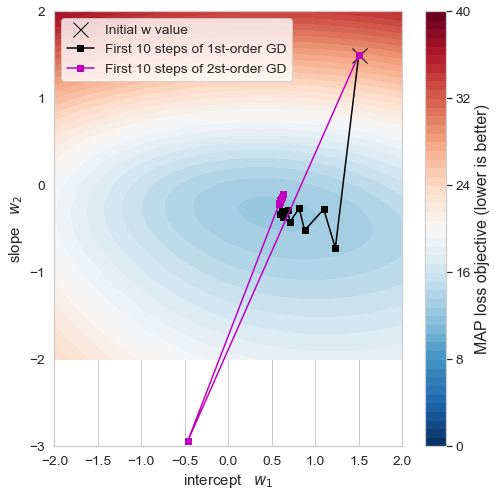

In [252]:
# Create a pretty contour plot over the grid of w[0], w[1], loss values

levels = np.linspace(0, 40, 51) # 50 evenly spaced levels

fig_handle, ax_handle = plt.subplots(nrows=1, ncols=1, figsize=(8,8));

ax_handle.contour(w0_GH, w1_GH, loss_GH, levels=levels, linewidths=0, colors='k')
cntrf_handle = ax_handle.contourf(w0_GH, w1_GH, loss_GH, levels=levels, cmap='RdBu_r', vmin=levels[0], vmax=levels[-1]);

cbar = plt.colorbar(cntrf_handle, ax=ax_handle)
cbar.set_label('MAP loss objective (lower is better)', fontsize=16);
cbar.set_ticks(levels[::10]);

# Show the first 10 iterates of GD
ax_handle.plot(whistory_GD1_T2[:1,0], whistory_GD1_T2[:1,1], 'kx', markersize=15, label='Initial w value')
ax_handle.plot(whistory_GD1_T2[:10,0], whistory_GD1_T2[:10,1], 'ks-', label='First 10 steps of 1st-order GD')
ax_handle.plot(whistory_GD2_T2[:10,0], whistory_GD2_T2[:10,1], 'ms-', label='First 10 steps of 2st-order GD')

plt.xlabel('intercept   $w_1$');
plt.ylabel('slope   $w_2$');
plt.gca().set_aspect('equal', 'box');
plt.ylim([-3, 2]);
plt.legend(loc='upper left');

## Discussion: Compare the *first step* that 1st-order GD took to the *first step* that 2nd-order GD took.

* Which is a better *direction*?
* Which ended up closer to the optimal value because of well-chosen step-length?

## Discussion: Compare the overall behavior of 1st and 2nd order GD.... do you see big qualitative differences?

* Which one makes faster progress toward the minimum?
* How are both sensitive to the step-size choice?